In [1]:
import argparse
import os
import math
import torchvision.transforms as transforms
from torchvision.utils import save_image
from torch.utils.data import DataLoader
from torchvision import datasets
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torch
import random
import torch
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import torchvision.datasets as dset
import matplotlib.pyplot as plt
# from torchsummary import summary
#os.chdir('D:/GANart/GAN-Artwork-Generation')
import time
from PIL import Image

In [2]:
print(torch.__version__)

1.13.0.dev20221004+cu117


In [5]:
import os

os.environ["CUDA_DEVICES_ORDER"]="PCI_BUS_IS"

os.environ["CUDA_VISIBLE_DEVICES"] = "0,1"
print(torch.cuda.device_count())
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"

2


In [4]:
# Saved in the d2l package for later use
class Timer(object): #定义一组功能，相当于库
    """Record multiple running times."""
    def __init__(self):
        self.times = []
        self.start()

    def start(self):
        # Start the timer
        self.start_time = time.time()

    def stop(self):
        # Stop the timer and record the time in a list
        self.times.append(time.time() - self.start_time)
        return self.times[-1]

    def avg(self):
        # Return the average time
        return sum(self.times)/len(self.times)

    def sum(self):
        # Return the sum of time
        return sum(self.times)

    def cumsum(self):
        # Return the accumuated times
        return np.array(self.times).cumsum().tolist()
timer = Timer()

In [6]:
# Root directory for dataset
dataroot = "C:/Users/Jackie/Desktop/science/gan-fl/d1000"

# Number of workers for dataloader
workers = 1


# Batch size during training
batch_size = 32

# Spatial size of training images. All images will be resized to this
#   size using a transformer.
image_size = 256

#number of calsses lable 
n_class = 1

# Number of channels in the training images. For color images this is 3
nc = 3

# Size of z latent vector (i.e. size of generator input)
nz = 100

# Size of feature maps in generator （output)
ngf = 64

# Size of feature maps in discriminator
ndf = 64

# Number of training epoc50
num_epochs = 50

# Learning rate for optimizers
lr = 0.0003

# Beta1 hyperparam for Adam optimizers
beta1 = 0.5

# Number of GPUs available. Use 0 for CPU mode.
ngpu = 2

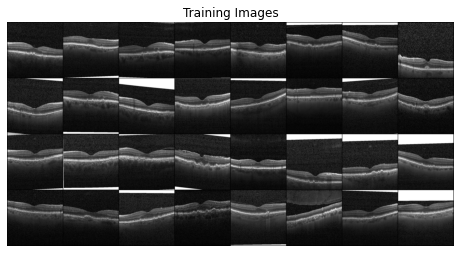

In [7]:
dataset = dset.ImageFolder(root=dataroot,
                           transform=transforms.Compose([
                               transforms.Resize(image_size),
                               transforms.CenterCrop(image_size),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                           ]))
# Create the dataloader
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                         shuffle=True, num_workers=workers)

# Decide which device we want to run on
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")

# Plot some training images
real_batch = next(iter(dataloader))
plt.figure(figsize=(8,8))
plt.axis("off")

plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))

In [8]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [10]:
#256 generator
class Generator(nn.Module):
    def __init__(self, ngpu=1):
        super(Generator, self).__init__()
        self.label_emb = nn.Embedding(n_class, n_class)
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d( nz + n_class, ngf * 16, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 16),
            nn.ReLU(True),
            # state size. (ngf*8) x 4 x 4
            nn.ConvTranspose2d(ngf * 16, ngf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf *8),
            nn.ReLU(True),
            # state size. (ngf*4) x 8 x 8
            nn.ConvTranspose2d( ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # state size. (ngf*2) x 16 x 16
            nn.ConvTranspose2d( ngf * 4, ngf * 3, 4, 2,1, bias=False),
            nn.BatchNorm2d(ngf*3),
            nn.ReLU(True),
            # state size. (ngf*2) x 32 x 32
            nn.ConvTranspose2d( ngf * 3, ngf*2, 4, 2,1, bias=False),
            nn.BatchNorm2d(ngf*2),
            nn.ReLU(True),
            # state size. (ngf) x 64 x 64
            nn.ConvTranspose2d( ngf*2, ngf, 4, 2,1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            # state size. (ngf) x 128 x 128
            nn.ConvTranspose2d(ngf, nc, 4, 2, 1, bias=False),
            nn.Tanh()
            # state size. (ngf) x 256 x 256
        )        

    def forward(self, noise_input, labels):
        # Concatenate label embedding and image to produce input
        #print(self.label_emb(labels).unsqueeze(2).unsqueeze(3).shape, noise_input.shape, labels.shape)
        gen_input = torch.cat((self.label_emb(labels).unsqueeze(2).unsqueeze(3), noise_input), 1)
        img = self.main(gen_input)
        img = img.view(img.size(0), *(nc, image_size, image_size))
        return img
    

In [11]:
# Create the generator
netG = Generator(ngpu).to(device)

# Handle multi-gpu if desired
if (device.type == 'cuda') and (ngpu > 1):
    netG = nn.DataParallel(netG, list(range(ngpu)))

# # Apply the weights_init function to randomly initialize all weights
# #  to mean=0, stdev=0.2.
netG.apply(weights_init)

# Print the model
print(netG)


DataParallel(
  (module): Generator(
    (label_emb): Embedding(1, 1)
    (main): Sequential(
      (0): ConvTranspose2d(101, 1024, kernel_size=(4, 4), stride=(1, 1), bias=False)
      (1): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): ConvTranspose2d(1024, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (4): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
      (6): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (7): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (8): ReLU(inplace=True)
      (9): ConvTranspose2d(256, 192, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (10): BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (11): ReLU(inplace=True)
      (12): ConvTranspose2d(1

In [12]:
#256
class Discriminator(nn.Module):
    def __init__(self, ngpu=1):
        super(Discriminator, self).__init__()
        #self.label_emb = nn.Embedding(n_class, n_class)
        self.label_emb = nn.Embedding(n_class, ndf*16*4)
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is (nc) x 256 x 256
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf) x 128 x 128
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*2) x 64 x 64
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*4) x 32 x 32
            nn.Conv2d(ndf * 4, ndf * 6, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 6),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*8) x 16 x 16
            #nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),
            #nn.Sigmoid()
            nn.Conv2d(ndf * 6, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*8) x 8 x 8
            nn.Conv2d(ndf * 8, ndf * 12, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 12),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*8) x 4 x 4
            nn.Conv2d(ndf * 12, ndf * 16, 4, 2, 1, bias=False), 
            nn.BatchNorm2d(ndf * 16),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*16) x 2 x 2
            nn.Flatten()
        )
        self.linear = nn.Sequential(
        #nn.Linear(hp.critic_size * 8, hp.critic_hidden_size),
        #nn.LeakyReLU(0.2, inplace=True),   
        #nn.Linear(n_class + 1, 1),
        #nn.Sigmoid()
        
        #nn.Linear(n_class + ndf * 8 * 16, ndf),
        nn.Linear(ndf*16*4*2, ndf*16),    
        #nn.BatchNorm1d(ndf*16),
        nn.LeakyReLU(0.2, inplace=True),   
        nn.Linear(ndf*16, 1),
        nn.Sigmoid()    
        )

    def forward(self, input, labels):
        disc_out = self.main(input)
        #print(input.shape, labels.shape, self.label_emb(labels).shape, disc_out.shape)
        #linear_input = torch.cat((self.label_emb(labels).unsqueeze(2).unsqueeze(3), disc_out), 1)
        linear_input = torch.cat((self.label_emb(labels), disc_out), 1)
        linear_output = self.linear(linear_input.squeeze())
        #print(input.shape, labels.shape, disc_out.shape, linear_input.shape, linear_output.shape)
        return linear_output.unsqueeze(2).unsqueeze(3)


In [13]:
# Create the Discriminator
netD = Discriminator(ngpu).to(device)

# Handle multi-gpu if desired
if (device.type == 'cuda') and (ngpu > 1):
    netD = nn.DataParallel(netD, list(range(ngpu)))

# # Apply the weights_init function to randomly initialize all weights
# #  to mean=0, stdev=0.2.
netD.apply(weights_init)
# Print the model
print(netD)

DataParallel(
  (module): Discriminator(
    (label_emb): Embedding(1, 4096)
    (main): Sequential(
      (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): LeakyReLU(negative_slope=0.2, inplace=True)
      (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (4): LeakyReLU(negative_slope=0.2, inplace=True)
      (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (7): LeakyReLU(negative_slope=0.2, inplace=True)
      (8): Conv2d(256, 384, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (9): BatchNorm2d(384, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (10): LeakyReLU(negative_slope=0.2, inplace=True)
      (11): Conv2d(384, 512, kernel_size=(

In [14]:
# Initialize BCELoss function
criterion = nn.BCELoss()

# Create batch of latent vectors that we will use to visualize
#  the progression of the generator
example_size = 1
fixed_noise = torch.randn(n_class*example_size, nz, 1, 1, device=device)
fixed_label = torch.tensor(list(np.repeat([i for i in range(n_class)], example_size))).type(torch.LongTensor).to(device)

# Establish convention for real and fake labels during training
real_label = 1.
fake_label = 0.

# Setup Adam optimizers for both G and D
optimizerD = optim.Adam(netD.parameters(), lr=0.08*lr, betas=(beta1, 0.999)) #Discriminator lr is different
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))  

In [16]:
from torchvision.utils import save_image 
img_save_path = 'images-dataroot' #save generate pictures
#os.makedirs("images", exist_ok=True)
os.makedirs(img_save_path, exist_ok=True)

In [ ]:
netD.load_state_dict(torch.load('netD-model1.params'))
netG.load_state_dict(torch.load('netG-model1.params'))

In [ ]:
netG1=netG
netD1=netD

In [ ]:
netD.load_state_dict(torch.load('netD-model2.params'))
netG.load_state_dict(torch.load('netG-model2.params'))

In [ ]:
netG2=netG
netD2=netD

In [ ]:
netD.load_state_dict(torch.load('netD-model3.params'))
netG.load_state_dict(torch.load('netG-model3.params'))

In [ ]:
netG3=netG
netD3=netD

In [ ]:
modelsG=[netG1,netG2,netG3]
modelsD=[netD1,netD2,netD3]

In [ ]:
import collections
worker_state_dictD = [x.state_dict() for x in modelsD]
weight_keysD = list(worker_state_dictD[0].keys())
fed_state_dictD = collections.OrderedDict()
for key in weight_keysD:
    key_sumD = 0
    for i in range(len(models)):
        key_sumD = key_sumD + worker_state_dictD[i][key]
    fed_state_dictD[key] = key_sumD / len(modelsD)

In [ ]:
worker_state_dict = [x.state_dict() for x in models]
weight_keys = list(worker_state_dict[0].keys())
fed_state_dict = collections.OrderedDict()
for key in weight_keys:
    key_sum = 0
    for i in range(len(models)):
        key_sum = key_sum + worker_state_dict[i][key]
    fed_state_dict[key] = key_sum / len(models)

In [ ]:
netG.load_state_dict(fed_state_dict)
netD.load_state_dict(fed_state_dictD)

In [ ]:

# Training Loop

# Lists to keep track of progress
img_list = []
G_losses = []
D_losses = []
iters = 0
timer.start()
print("Starting Training Loop...")
# For each epoch
for epoch in range(num_epochs):
    # For each batch in the dataloader 
    for i, (data, real_style_labels) in enumerate(dataloader, 0):
        

        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        ## Train with all-real batch
        netD.zero_grad()
        # Format batch
        real_cpu = data.to(device)
        b_size = real_cpu.size(0)
        label = torch.full((b_size,), real_label, dtype=torch.float, device=device)
        # style labels - iso
        real_style_labels = real_style_labels.to(device)
        fake_style_labels = torch.tensor(np.random.choice(n_class, size = b_size)).type(torch.LongTensor).to(device)
        # Forward pass real batch through D
        output = netD(gaussian(real_cpu, mean=0, stddev=0.5*0.01**(epoch/num_epochs)), real_style_labels).view(-1)
        # Calculate loss on all-real batch
        errD_real = criterion(output, label)
        # Calculate gradients for D in backward pass
        errD_real.backward()
        D_x = output.mean().item()

        ## Train with all-fake batch
        # Generate batch of latent vectors
        noise = torch.randn(b_size, nz, 1, 1, device=device)
        # Generate fake image batch with G
        fake = netG(noise, fake_style_labels)
        label.fill_(fake_label)
        # Classify all fake batch with D
        output = netD(fake.detach(), fake_style_labels).view(-1)
        # Calculate D's loss on the all-fake batch
        errD_fake = criterion(output, label)
        # Calculate the gradients for this batch
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        # Add the gradients from the all-real and all-fake batches
        errD = errD_real + errD_fake
        # Update D
        optimizerD.step()

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        netG.zero_grad()
        label.fill_(real_label)  # fake labels are real for generator cost
        # Since we just updated D, perform another forward pass of all-fake batch through D
        output = netD(fake, fake_style_labels).view(-1)
        # Calculate G's loss based on this output
        errG = criterion(output, label)
        # Calculate gradients for G
#         print('befor backward',errG)
        errG.backward()
#         print('After backward',errG)
        D_G_z2 = output.mean().item()
        # Update G
        optimizerG.step()

        # Output training stats
        if i % 200 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch, num_epochs, i, len(dataloader),
                     errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))

        # Save Losses for plotting later
        G_losses.append(errG.item())
        D_losses.append(errD.item())

        # Check how the generator is doing by saving G's output on fixed_noise
        #if (iters % 2000 == 0) or ((epoch == num_epochs-1) and (i == len(dataloader)-1)):
        if (i == len(dataloader)-1):
            with torch.no_grad():
                fake = netG(fixed_noise, fixed_label).detach().cpu()
            img_list.append(vutils.make_grid(fake, nrow = example_size,padding=2, normalize=True))
            save_image(fake.data, img_save_path + '/%d-%d.png' % (epoch,iters), nrow=example_size, normalize=True)

        iters += 1
torch.save(netD.state_dict(), 'netD-oct-1013-5e-4-4000-second-1500.params')
torch.save(netG.state_dict(), 'netG-oct-1013-5e-4-4000-second-1500.params')
'%.5f sec' % timer.stop()

In [ ]:
# generate fake picture to caculate MMD score

timer.start()
from torchvision.utils import save_image
img_save_path_fake = 'netG-Fakepcitres-1'
#os.makedirs("images", exist_ok=True)
os.makedirs(img_save_path_fake, exist_ok=True)
for i in range(1500):
    fixed_noise = torch.randn(n_class*example_size, nz, 1, 1, device=device)
    fixed_label = torch.tensor(list(np.repeat([i for i in range(n_class)], example_size))).type(torch.LongTensor).to(device)
    fake = netG(fixed_noise, fixed_label).detach().cpu()
    save_image(fake.data, img_save_path_fake + '/'+str(i)+'.png', nrow=example_size, normalize=True)
'%.5f sec' % timer.stop()